/var/folders/sd/x6b24fj17sg_pd8tj67xfp4r0000gn/T/ipykernel_87283/3808449857.py:68: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  all_data.fillna(method='ffill', inplace=True)



📊 Selected features for 7-day prediction: ['sp500_close', 'treasury_3m_treasury_3m', 'stoxx_600_High', 'stoxx_600_Low', 'stoxx_600_Open', 'unemployment_unemployment_rate', 'bitcoin_Open', 'stoxx_600_Close']
📈 7-day forecast:
   R²:   0.9898
   MAE:  5.2292
   MSE:  54.6401
   RMSE: 7.3919


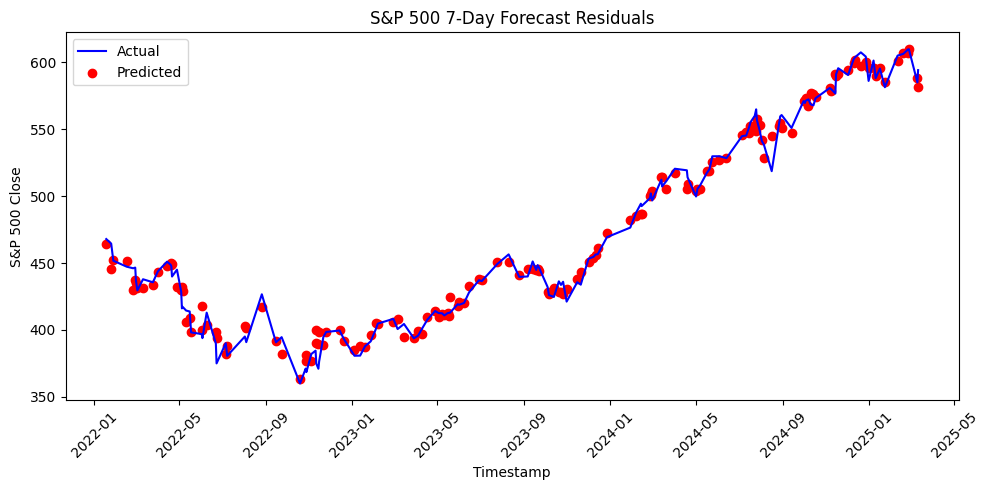


📊 Selected features for 30-day prediction: ['unemployment_unemployment_rate', 'bitcoin_Open', 'bitcoin_Low', 'sse_Close', 'bitcoin_High', 'treasury_3m_treasury_3m', 'stoxx_600_High', 'bitcoin_bitcoin_close', 'stoxx_600_Close', 'google_trends_index fund']
📈 30-day forecast:
   R²:   0.9766
   MAE:  6.4971
   MSE:  116.9917
   RMSE: 10.8163


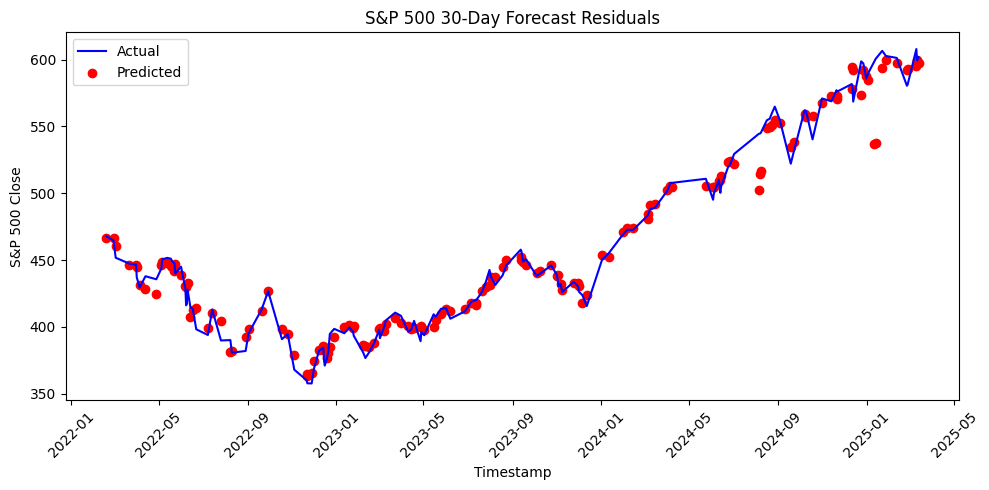


📊 Selected features for 180-day prediction: ['sp500_close', 'treasury_3m_treasury_3m', 'stoxx_600_Open', 'stoxx_600_High', 'bitcoin_High', 'stoxx_600_Low']
📈 180-day forecast:
   R²:   0.9698
   MAE:  6.1540
   MSE:  64.0482
   RMSE: 8.0030


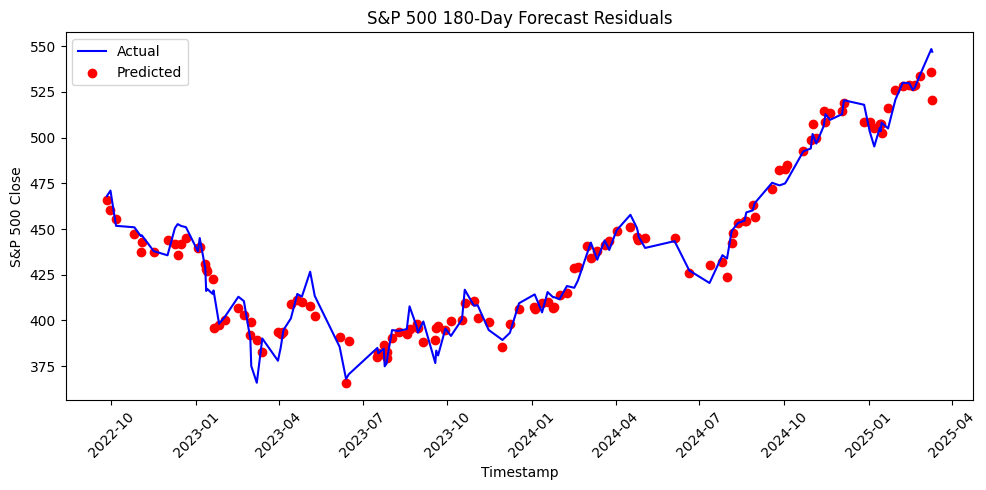


✅ Final results:
7-day → R²: 0.9898, MAE: 5.23, RMSE: 7.39
30-day → R²: 0.9766, MAE: 6.50, RMSE: 10.82
180-day → R²: 0.9698, MAE: 6.15, RMSE: 8.00


In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.inspection import permutation_importance

# File definitions
data_path = "data"
file_names = {
    "bitcoin": "bitcoin.csv",
    "gold": "gold.csv",
    "google_trends": "google_trends.csv",
    "sp500": "sp500.csv",
    "treasury_3m": "treasury_3m.csv",
    "treasury_10y": "treasury_10y.csv",
    "copper": "copper.csv",
    "oil": "oil.csv",
    "unemployment": "unemployment.csv",
    "moex": "MOEX.csv",
    "sse": "SSE.csv",
    "stoxx_600": "STOXX_600.csv"
}

# Load datasets
data = {}
for key, file in file_names.items():
    file_path = os.path.join(data_path, file)
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        if "timestamp" in df.columns:
            df["timestamp"] = pd.to_datetime(df["timestamp"])
            for col in df.columns:
                if col != "timestamp":
                    df[col] = pd.to_numeric(df[col], errors='coerce')
            data[key] = df
        else:
            print(f"⚠️ Skipping {key}: missing 'timestamp' column")
    else:
        print(f"❌ File not found: {file_path}")

# Rename standard columns for key datasets
rename_map = {
    "sp500": {"Close": "sp500_close"},
    "copper": {"price": "copper_price"},
    "oil": {"Close": "oil_close"},
    "unemployment": {"Unemployment": "unemployment_rate"},
    "bitcoin": {"Close": "bitcoin_close"},
    "gold": {"Close": "gold_close"},
}
for key, renames in rename_map.items():
    if key in data:
        data[key] = data[key].rename(columns=renames)

# Merge datasets with prefixing (except sp500)
sp500 = data["sp500"]
all_data = sp500[["timestamp", "sp500_close"]]

for key, df in data.items():
    if key != "sp500":
        df = df.rename(columns={col: f"{key}_{col}" for col in df.columns if col != "timestamp"})
        all_data = all_data.merge(df, on="timestamp", how="left")

# Final clean
all_data.sort_values("timestamp", inplace=True)
all_data.fillna(method='ffill', inplace=True)
all_data.dropna(inplace=True)

# Define prediction intervals
prediction_intervals = [7, 30, 180]
results = {}

for interval in prediction_intervals:
    all_data[f"sp500_target_{interval}"] = all_data["sp500_close"].shift(interval)
    model_data = all_data.dropna(subset=[f"sp500_target_{interval}"])

    feature_columns = [col for col in model_data.columns if col not in ["timestamp"] + [f"sp500_target_{i}" for i in prediction_intervals]]
    X = model_data[feature_columns]
    y = model_data[f"sp500_target_{interval}"]
    timestamps = model_data["timestamp"]

    X_train, X_test, y_train, y_test, timestamps_train, timestamps_test = train_test_split(
        X, y, timestamps, test_size=0.2, random_state=42)

    model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
    model.fit(X_train, y_train)

    importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
    sorted_idx = importance.importances_mean.argsort()[::-1]
    selected_features = [feature_columns[i] for i in sorted_idx if importance.importances_mean[i] > 0.01]

    print(f"\n📊 Selected features for {interval}-day prediction:", selected_features)

    # Retrain with selected features
    X_train_sel = X_train[selected_features]
    X_test_sel = X_test[selected_features]
    model.fit(X_train_sel, y_train)

    y_pred = model.predict(X_test_sel)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    results[interval] = {"R²": r2, "MAE": mae, "MSE": mse, "RMSE": rmse}

    print(f"📈 {interval}-day forecast:")
    print(f"   R²:   {r2:.4f}")
    print(f"   MAE:  {mae:.4f}")
    print(f"   MSE:  {mse:.4f}")
    print(f"   RMSE: {rmse:.4f}")

    sorted_indices = np.argsort(timestamps_test.values)
    ts_sorted = timestamps_test.values[sorted_indices]
    y_test_sorted = y_test.values[sorted_indices]
    y_pred_sorted = y_pred[sorted_indices]

    plt.figure(figsize=(10, 5))
    plt.plot(ts_sorted, y_test_sorted, label="Actual", color="blue")
    plt.scatter(ts_sorted, y_pred_sorted, label="Predicted", color="red", marker="o")
    plt.title(f"S&P 500 {interval}-Day Forecast Residuals")
    plt.xlabel("Timestamp")
    plt.ylabel("S&P 500 Close")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Final metrics
print("\n✅ Final results:")
for interval, metrics in results.items():
    print(f"{interval}-day → R²: {metrics['R²']:.4f}, MAE: {metrics['MAE']:.2f}, RMSE: {metrics['RMSE']:.2f}")
